# Customer Segmentation Using Clustering Algorithms

**Author:** Matt Cocker  
**Date:** [April, 2025]  
**Project Type:** Unsupervised ML | Clustering | Customer Analytics

---

## About this Notebook

This notebook applies clustering algorithms to segment a customer dataset based on behavioural and demographic features. The aim is to identify distinct customer groups that can inform personalised marketing strategies and improve product targeting.

The analysis includes data preparation, feature selection, visualisation, and evaluation of clustering results using K-Means and silhouette analysis.

**Key Tasks:**
- Clean and scale customer data
- Apply clustering techniques to identify meaningful segments
- Visualise clusters and interpret behavioural patterns
- Recommend business actions based on segment characteristics

# Imports

In [ ]:
# Step 1: Import the required libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Data Import & Preprocessing

In [ ]:
# Step 2: Import the dataset from Github

data = pd.read_csv('https://github.com/FourthRevGitHub/CAM_DS_Public-Data-Sets/raw/main/Course%201/Week%206/CUSTOMERS_CLEAN.zip')

# Step 3: View the metadata

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951669 entries, 0 to 951668
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Quantity              951669 non-null  int64 
 1   City                  951534 non-null  object
 2   Continent             951669 non-null  object
 3   Postal_Code           947953 non-null  object
 4   State_Province        834477 non-null  object
 5   Order_Date            951669 non-null  object
 6   Delivery_Date         951669 non-null  object
 7   Total Revenue         951669 non-null  object
 8   Unit Cost             951669 non-null  object
 9   Discount              951669 non-null  object
 10  OrderTypeLabel        951669 non-null  object
 11  CustomerCountryLabel  951669 non-null  object
 12  Customer_BirthDate    951669 non-null  object
 13  Customer_Group        951669 non-null  object
 14  Customer_Type         951669 non-null  object
 15  Order ID         

The metadata confirms missing values, however they are all in the same category (address). Given that this data has ethical concerns (using too specific an identifier, such as an address, would risk violating customer privacy), this can be disregarded. The "CustomerCountryLabel" data has no missing values, therefore that can be used for any geographic purposes.

In [ ]:
# Step 4: Confirm presence of duplicate values

data.duplicated().sum()

np.int64(21)

There are 21 duplicate rows - in order to ensure data integrity, these must be removed.

Here I will also remove the City, Postal Code and State Province features, as they are not necessary and including them risks violating customer privacy.

In [ ]:
# Step 5: Remove duplicate rows

data = data.drop_duplicates()

data.head()

# Step 6: Remove the City, Postal Code and State Province features

data = data.drop(['City', 'Postal_Code', 'State_Province'], axis=1)

data.head()

,Quantity,Continent,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,CustomerCountryLabel,Customer_BirthDate,Customer_Group,Customer_Type,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID
0,3,Oceania,01JAN2012,07JAN2012,$28.50,$9.10,.,Internet Sale,Australia,08MAY1978,Internet/Catalog Customers,Internet/Catalog Customers,1230000033,$1.20,6,99,8818
1,2,Oceania,01JAN2012,04JAN2012,$113.40,$56.90,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,($0.40),3,99,47793
2,2,Oceania,01JAN2012,04JAN2012,$41.00,$18.50,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,$4.00,3,99,47793
3,1,Oceania,01JAN2012,03JAN2012,$35.20,$29.60,.,Internet Sale,Australia,22JUN1997,Orion Club Gold members,Orion Club Gold members high activity,1230000268,$5.60,2,0,71727
4,1,North America,01JAN2012,04JAN2012,$24.70,$23.60,.,Internet Sale,Canada,28JAN1978,Orion Club Gold members,Orion Club Gold members medium activity,1230000487,$1.10,3,99,74503


In [ ]:
# Step 7: Double check there are no more missing values

data.isna().sum()

,0
Quantity,0
Continent,0
Order_Date,0
Delivery_Date,0
Total Revenue,0
Unit Cost,0
Discount,0
OrderTypeLabel,0
CustomerCountryLabel,0
Customer_BirthDate,0


It was shown in Step 3 that most of the data was of the "object" datatype. These will need to be converted to perform feature engineering.

In [ ]:
# Step 8: Convert the datatypes from "Object" to the appropriate type

  # Convert to dates

data['Order_Date'] = pd.to_datetime(data['Order_Date'], format='%d%b%Y')
data['Delivery_Date'] = pd.to_datetime(data['Delivery_Date'], format='%d%b%Y')
data['Customer_BirthDate'] = pd.to_datetime(data['Customer_BirthDate'], format='%d%b%Y')

  # Remove the dollar sign and space, then change to datatype to float.

data['Total Revenue'] = data['Total Revenue'].str.replace('$', '').str.replace(',', '').astype(float)
data['Unit Cost'] = data['Unit Cost'].str.replace('$', '').str.replace(',', '').astype(float)
data['Profit'] = data['Profit'].str.replace('$', '').str.replace(',', '').str.replace('(', '-').str.replace(')', '').astype(float)

data.head()


,Quantity,Continent,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,CustomerCountryLabel,Customer_BirthDate,Customer_Group,Customer_Type,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID
0,3,Oceania,2012-01-01,2012-01-07,28.5,9.1,.,Internet Sale,Australia,1978-05-08,Internet/Catalog Customers,Internet/Catalog Customers,1230000033,1.2,6,99,8818
1,2,Oceania,2012-01-01,2012-01-04,113.4,56.9,.,Internet Sale,Australia,1978-12-13,Orion Club Gold members,Orion Club Gold members high activity,1230000204,-0.4,3,99,47793
2,2,Oceania,2012-01-01,2012-01-04,41.0,18.5,.,Internet Sale,Australia,1978-12-13,Orion Club Gold members,Orion Club Gold members high activity,1230000204,4.0,3,99,47793
3,1,Oceania,2012-01-01,2012-01-03,35.2,29.6,.,Internet Sale,Australia,1997-06-22,Orion Club Gold members,Orion Club Gold members high activity,1230000268,5.6,2,0,71727
4,1,North America,2012-01-01,2012-01-04,24.7,23.6,.,Internet Sale,Canada,1978-01-28,Orion Club Gold members,Orion Club Gold members medium activity,1230000487,1.1,3,99,74503


# Feature Engineering

With dates in a consistent format and dollar values now as numerical values rather than text, it is possible to transform the data to create new features.

In [ ]:
# Step 9: Create new features

  # Frequency

data['Frequency'] = data.groupby('Customer ID')['Order ID'].transform('count')

  # Recency (Subtracting 3000 to make the data more time-appropriate)

data['Recency'] = ((datetime.today() - data['Order_Date']).dt.days)-3000
data['Recency'] = data.groupby('Customer ID')['Recency'].transform('min')

  # Customer Lifetime Value (CLV)

data['CLV'] = data.groupby('Customer ID')['Profit'].transform('sum')

  # Average Unit Cost

data['Average Unit Cost'] = data.groupby('Customer ID')['Unit Cost'].transform('mean')

  # Age

data['Age'] = ((datetime.today() - data['Customer_BirthDate']).dt.days)/365
data['Age'] = data['Age'].astype(int)

data.head()

,Quantity,Continent,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,CustomerCountryLabel,Customer_BirthDate,...,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID,Frequency,Recency,CLV,Average Unit Cost,Age
0,3,Oceania,2012-01-01,2012-01-07,28.5,9.1,.,Internet Sale,Australia,1978-05-08,...,1230000033,1.2,6,99,8818,31,401,79.6,60.206452,46
1,2,Oceania,2012-01-01,2012-01-04,113.4,56.9,.,Internet Sale,Australia,1978-12-13,...,1230000204,-0.4,3,99,47793,20,161,11.3,66.280000,46
2,2,Oceania,2012-01-01,2012-01-04,41.0,18.5,.,Internet Sale,Australia,1978-12-13,...,1230000204,4.0,3,99,47793,20,161,11.3,66.280000,46
3,1,Oceania,2012-01-01,2012-01-03,35.2,29.6,.,Internet Sale,Australia,1997-06-22,...,1230000268,5.6,2,0,71727,20,91,160.7,74.775000,27
4,1,North America,2012-01-01,2012-01-04,24.7,23.6,.,Internet Sale,Canada,1978-01-28,...,1230000487,1.1,3,99,74503,6,776,133.5,74.300000,47


**Frequency:**

Order ID is always a unique value per order so that is used to ensure that the count of number of orders is accurate. Whilst a more complex metric could be used by subtracting the earliest order date from the most recent order date per customer and dividing that by the number of orders, a simple count of the number of orders by a given customer is used here to avoid any sort of Recency Bias where new customers seem to have a higher frequency than long term customers.

**Recency:**

Pre-subtraction, the most recent order was 3008 days ago. I am making the assumption that this data is intended to be representative of current sales. As such, 3000 is subtracted from the 'Recency' feature to ensure the scale and range of the data are representative of a timely dataset.

**Customer Lifetime Value (CLV):**

Here the total Profit the company generates per individual customer is used. This ensures that customers who purchase a high volume of items which the company makes a loss on do not erroneously appear to be high value, as they would if another metric such as Total Revenue were used.

This distinction allows the company to correctly identify customers who are bargain hunters, and therefore the company can target marketing to them accordingly.

**Average Unit Cost:**

This is quite simply the mean Unit Cost of all items purchased by a customer. This allows the company to identify customer purchasing habits; whether they in general like expensive or cheap items.

**Age:**

Knowing the age of customers may allow the company to make judgements over what kind of advertising they are most likely to respond to, among other insights.

# Exploratory Data Analysis

In [ ]:
# Step 10: Create new DataFrame with new features

clean = pd.DataFrame(data[['Customer ID', 'Frequency', 'Recency', 'CLV', 'Average Unit Cost', 'Age']])

clean = clean.drop_duplicates()

clean.head()

,Customer ID,Frequency,Recency,CLV,Average Unit Cost,Age
0,8818,31,401,79.6,60.206452,46
1,47793,20,161,11.3,66.280000,46
3,71727,20,91,160.7,74.775000,27
4,74503,6,776,133.5,74.300000,47
5,8610,3,318,3.1,183.866667,61


In [ ]:
# Step 11: Double check that count of unique Customer ID is the same across both datasets

clean['Customer ID'].nunique() == data['Customer ID'].nunique()

True

In [ ]:
# Step 12: Having successfully created a DataFrame with new features for individual customers, set Customer ID as the index

clean = clean.set_index('Customer ID')

# Step 13: Check the distributions of our data

clean.describe()


,Frequency,Recency,CLV,Average Unit Cost,Age
count,68300.000000,68300.000000,68300.000000,68300.000000,68300.000000
mean,13.933353,387.662167,120.926783,78.895675,51.416442
std,11.328807,414.511202,159.875970,38.005259,17.493276
min,1.000000,20.000000,-1153.150000,0.500000,27.000000
25%,6.000000,65.000000,26.800000,57.579792,36.000000
50%,11.000000,210.000000,83.890000,73.450000,51.000000
75%,19.000000,559.250000,175.900000,92.515260,66.000000
max,121.000000,1844.000000,2630.380000,1463.500000,82.000000


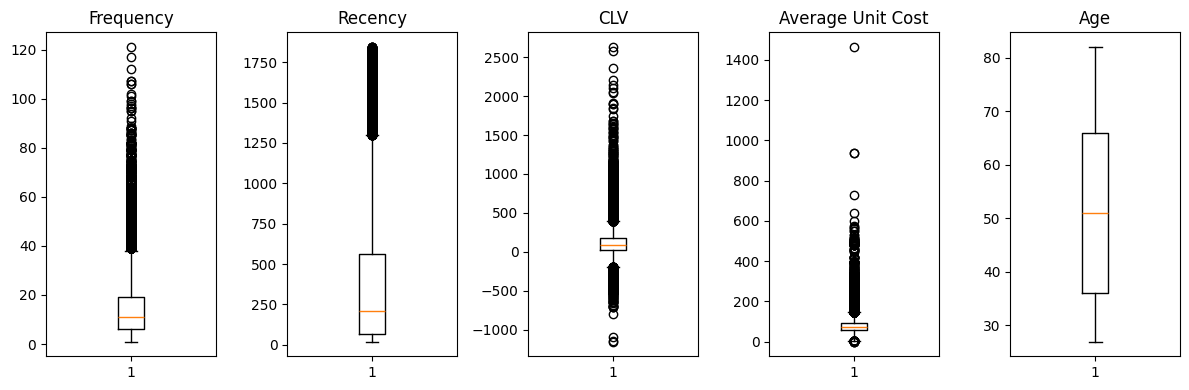

In [ ]:
# Step 14: Plot each feature on a separate boxplot to check for outliers

plt.figure(figsize=(12, 4))

plt.subplot(1, 5, 1)
plt.boxplot(clean['Frequency'])
plt.title('Frequency')

plt.subplot(1, 5, 2)
plt.boxplot(clean['Recency'])
plt.title('Recency')

plt.subplot(1, 5, 3)
plt.boxplot(clean['CLV'])
plt.title('CLV')

plt.subplot(1, 5, 4)
plt.boxplot(clean['Average Unit Cost'])
plt.title('Average Unit Cost')

plt.subplot(1, 5, 5)
plt.boxplot(clean['Age'])
plt.title('Age')

plt.tight_layout()
plt.show()

There are clearly some significant outliers in the data - in particular in the 'Average Unit Cost' and 'Customer Lifetime Value' features. Given that clustering algorithms are sensitive to outliers, it would be prudent to remove the most egregious ones to ensure effective clustering.

I will use the Isolation Forest model to detect anomalies, as it is simple to use and is efficient with large datasets. I have chosen a contamination of 0.015 corresponding with 1.5% of the dataset being anomalous.

Removing these outliers will ensure effective clustering, and, given they make up a small proportion of the overall data, will not have a negative impact on the final results.

In [ ]:
# Step 15: Create an Isolation Forest model to detect anomalies in the data

iso = IsolationForest(contamination=0.015, random_state=19)

iso.fit(clean)

IsolationForest(contamination=0.015, random_state=19)

In [ ]:
# Step 16: Predict the classification of each datapoint as normal (1) or anomaly (-1)

clean['Anomaly'] = iso.predict(clean)

# Step 17: Remove any sample which has been flagged as anomalous

clean = clean[clean['Anomaly'] == 1]

clean = clean.drop('Anomaly', axis=1)

clean.describe()

,Frequency,Recency,CLV,Average Unit Cost,Age
count,67275.000000,67275.000000,67275.000000,67275.000000,67275.000000
mean,13.807611,382.771639,118.098597,77.033304,51.401085
std,10.795086,409.053263,148.447972,31.182175,17.462501
min,1.000000,20.000000,-1153.150000,0.500000,27.000000
25%,6.000000,65.000000,27.200000,57.358957,36.000000
50%,11.000000,207.000000,84.000000,73.109091,51.000000
75%,19.000000,551.000000,174.500000,91.762587,66.000000
max,95.000000,1844.000000,2630.380000,337.252000,82.000000


# Clustering

With anomalies removed, I can start identifying the optimal number of clusters for k-means clustering.

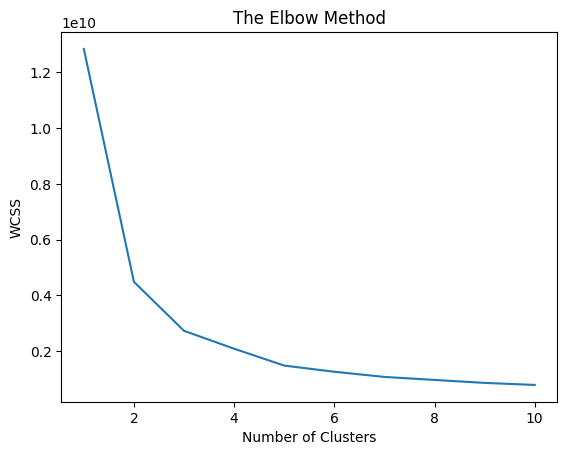

In [ ]:
# Step 18: Ascertain the optimal number of clusters for k-means Clustering using the elbow method

wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, init='k-means++', random_state=19, n_init = 10)
    kmeans.fit(clean)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

The above chart shows that the kinks are at 2, 3 and 5 clusters.

As the kink with the lowest WCSS is at 5 on the x-axis, the optimal number of clusters is 5. To ensure that is the case, I'll use the silhouette scores to double check.

In [ ]:
# Step 19: Ascertain the optimal number of clusters for k-means clustering using the silhouette score method

for i in range(2, 8):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=19, n_init=10)
    labels = kmeans.fit_predict(clean)
    sil_avg = silhouette_score(clean, labels)
    print(f"For n_clusters = {i}, the average silhouette_score is : {sil_avg}")

For n_clusters = 2, the average silhouette_score is : 0.6170260061699187
For n_clusters = 3, the average silhouette_score is : 0.520917224490823
For n_clusters = 4, the average silhouette_score is : 0.4521334598563208
For n_clusters = 5, the average silhouette_score is : 0.4618903123407191
For n_clusters = 6, the average silhouette_score is : 0.4597847500580254
For n_clusters = 7, the average silhouette_score is : 0.3909533184495828


The silhouette score trends downwards but the silhouette score for 5 clusters breaks that trend. This means we can dismiss 4, 6 or 7 clusters as a possibility, as they all have a lower average silhouette score than 5 clusters, and that 5 clusters is the optimum number. This corresponds with the elbow method above.

Plotting a dendogram will confirm the optimal number of clusters.

In [ ]:
# Step 20: Perform hierarchical clustering on the dataset
  # Use a random sample of the data

clean_a = clean.sample(n=20000, random_state=19)

agglom = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='average')
clean_a['Cluster'] = agglom.fit_predict(clean_a)

Agglomerative hierarchical clustering on the full dataset takes up all the RAM on my laptop, therefore I am using a random sample of the data. Ideally this operation would be performed on a PC with more processing power, at which point the full dataset could be used.

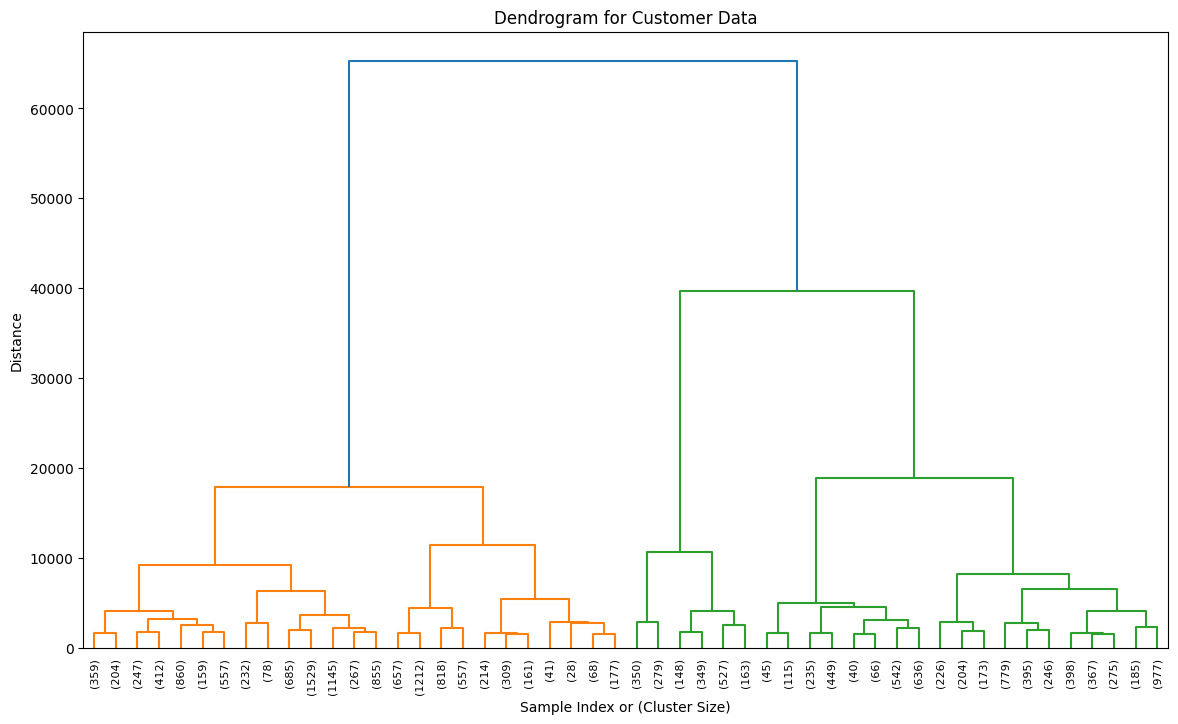

In [ ]:
# Step 21: Create the linkage matrix and plot the dendogram

clean_d = clean_a.drop('Cluster', axis=1)

Z = linkage(clean_d, method='ward')
plt.figure(figsize=(14, 8))
dendrogram(Z, truncate_mode='lastp', p=50)
plt.title('Dendrogram for Customer Data')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.show()

The dendogram shows that 5 clusters ensures all samples in each cluster are within a reasonable distance of each other.

Now I can proceed to performing k-means clustering with 5 clusters.

In [ ]:
# Step 22: Perform k-means clustering with 5 clusters

clean_k = clean.copy()

kmeans = KMeans(n_clusters=5, n_init=10, random_state=19)
clean_k['Cluster'] = kmeans.fit_predict(clean_k)

clean_k.head()

,Frequency,Recency,CLV,Average Unit Cost,Age,Cluster
Customer ID,,,,,,
8818,31,401,79.6,60.206452,46,2
47793,20,161,11.3,66.280000,46,0
71727,20,91,160.7,74.775000,27,0
74503,6,776,133.5,74.300000,47,1
8610,3,318,3.1,183.866667,61,2


# Dimensionality Reduction

To perform dimensionality reduction, the data needs to be standardised.

In [ ]:
# Step 23: Standardise the dataset

scaler = StandardScaler()

clean_std = scaler.fit_transform(clean)

clean_std = pd.DataFrame(clean_std, columns=clean.columns)

clean_std.head()

,Frequency,Recency,CLV,Average Unit Cost,Age
0,1.592624,0.044563,-0.259343,-0.539635,-0.309298
1,0.573635,-0.542162,-0.719440,-0.344857,-0.309298
2,0.573635,-0.713291,0.286981,-0.072423,-1.397352
3,-0.723261,0.961320,0.103750,-0.087657,-0.252033
4,-1.001168,-0.158346,-0.774678,3.426129,0.549691


In [ ]:
# Step 24: Use PCA to reduce the dimensions of the dataset

pca = PCA(n_components=2)

clean_pca = pca.fit_transform(clean_std)

clean_pca = pd.DataFrame(clean_pca, columns=['PC1', 'PC2'])

clean_pca = clean_pca.set_index(clean.index)

clean_pca = clean_pca.join(clean_k['Cluster'])

clean_pca.head()

,PC1,PC2,Cluster
Customer ID,,,
8818,0.856537,-0.538250,2
47793,0.258847,-0.167640,0
71727,1.166886,0.368684,0
74503,-0.813700,0.090732,1
8610,-0.854016,3.114695,2


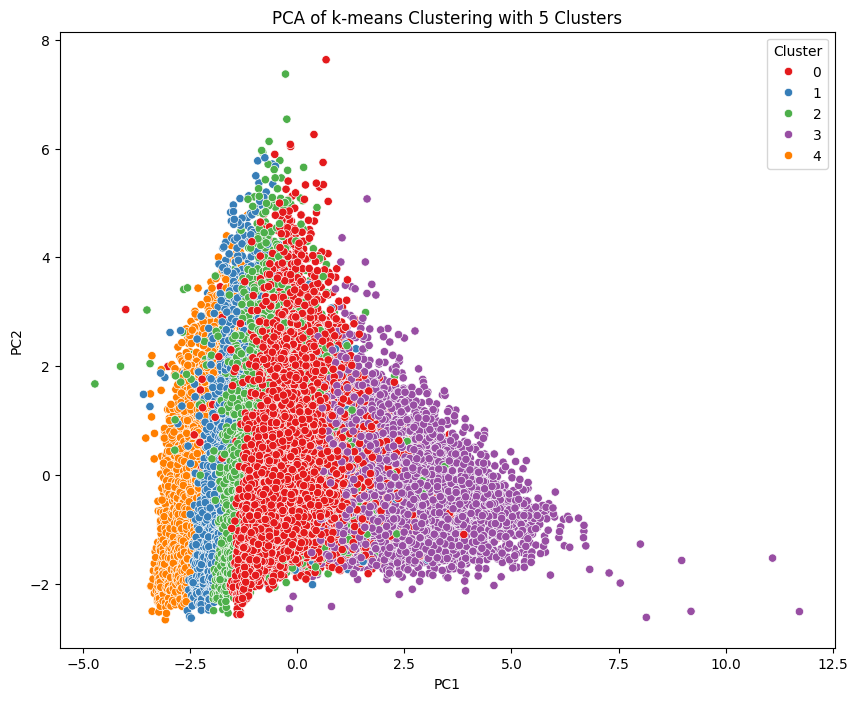

In [ ]:
# Step 25: Show the scatter plot with each cluster in a different colour.

plt.figure(figsize=(10, 8))
sns.scatterplot(data=clean_pca, x='PC1', y='PC2', hue='Cluster', palette='Set1')
plt.title('PCA of k-means Clustering with 5 Clusters')
plt.show()

The above plot is not particularly clear, therefore a different method to reduce the dimensions of the dataset must be used.

In [ ]:
# Step 26: Use tSNE to reduce the dimensions of the dataset

tsne = TSNE(n_components=2, perplexity=20, random_state=19)

clean_tsne = tsne.fit_transform(clean_std)

clean_tsne = pd.DataFrame(clean_tsne, columns=['C1', 'C2'])

clean_tsne = clean_tsne.set_index(clean.index)

clean_tsne5 = clean_tsne.join(clean_k['Cluster'])

clean_tsne.head()

,C1,C2
Customer ID,,
8818,37.384502,-8.762855
47793,16.851112,25.409037
71727,72.540161,70.028969
74503,-64.056297,12.972573
8610,-36.688332,22.452387


Through trial and error I have settled on a perplexity of 20. There was little variation in the output - overlapping was not preventable.

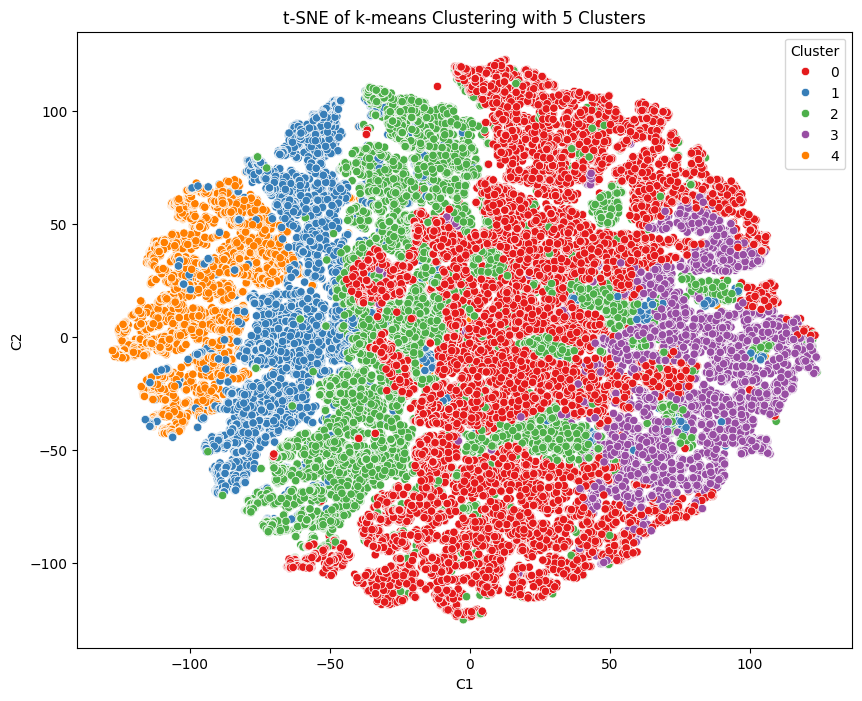

In [ ]:
# Step 27: Show the scatter plot with each cluster in a different colour

plt.figure(figsize=(10, 8))
sns.scatterplot(data=clean_tsne5, x='C1', y='C2', hue='Cluster', palette='Set1')
plt.title('t-SNE of k-means Clustering with 5 Clusters')
plt.show()

The above plot shows that there are 5 distinct clusters, however, barring Clusters 3 and 4, there is significant overlap.



# Conclusions

To understand the properties of each cluster, I will need to generate boxplots for each feature.

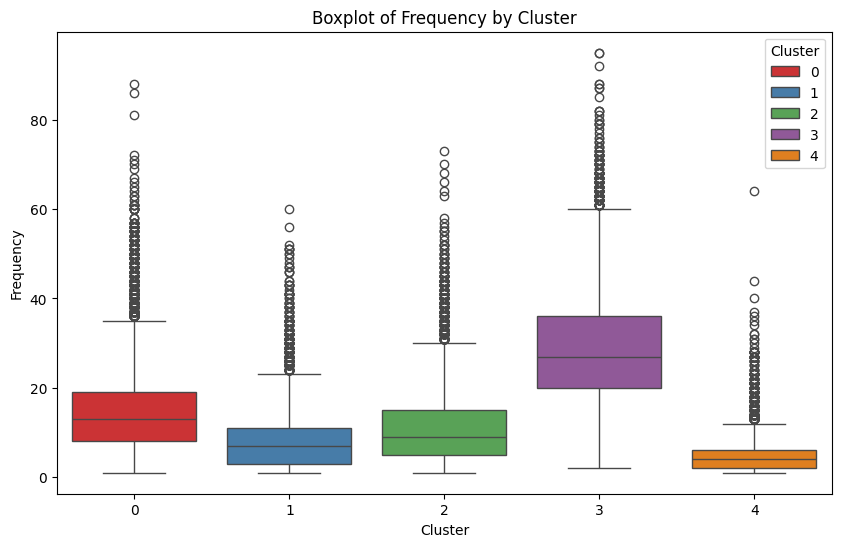

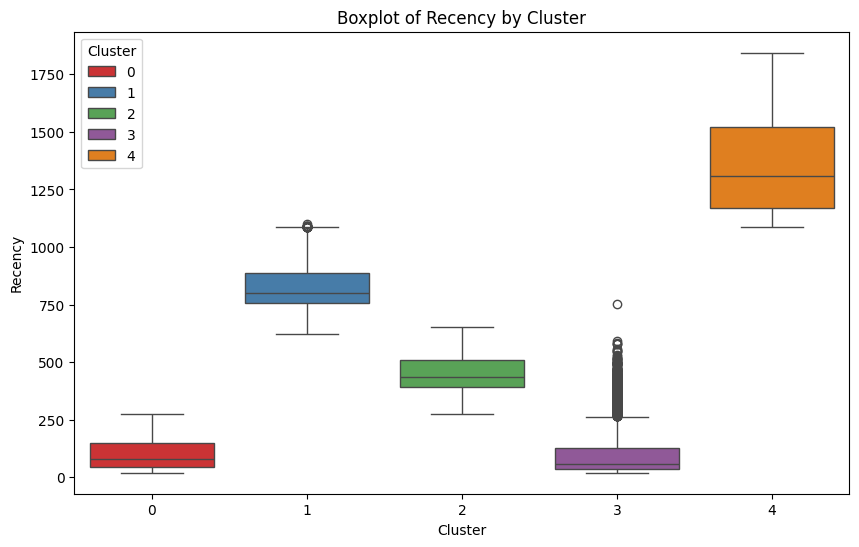

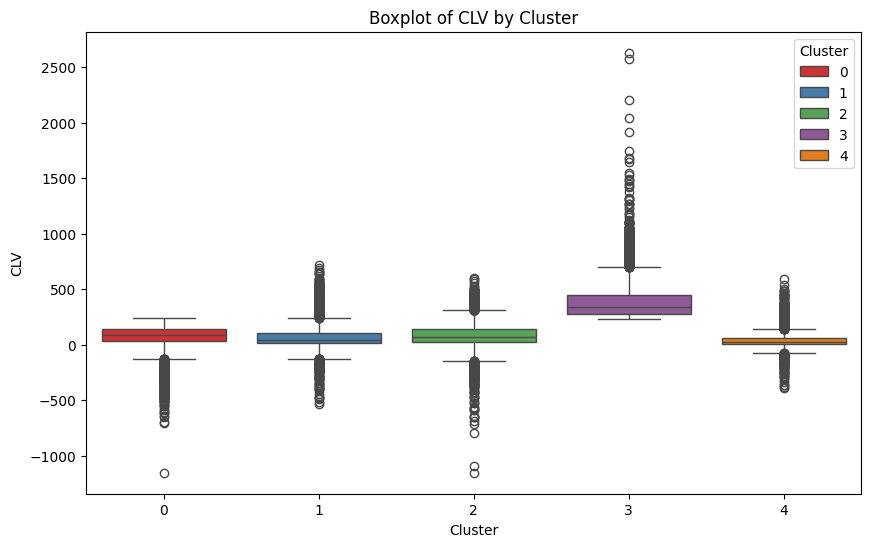

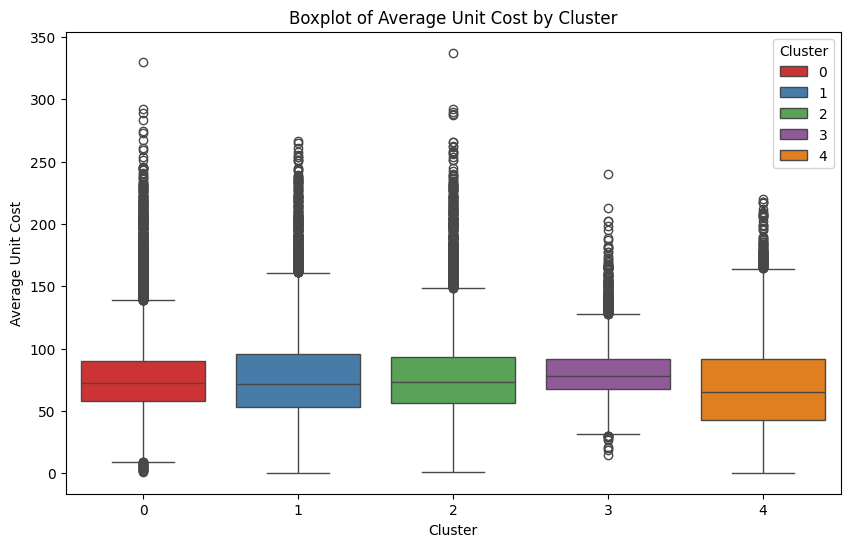

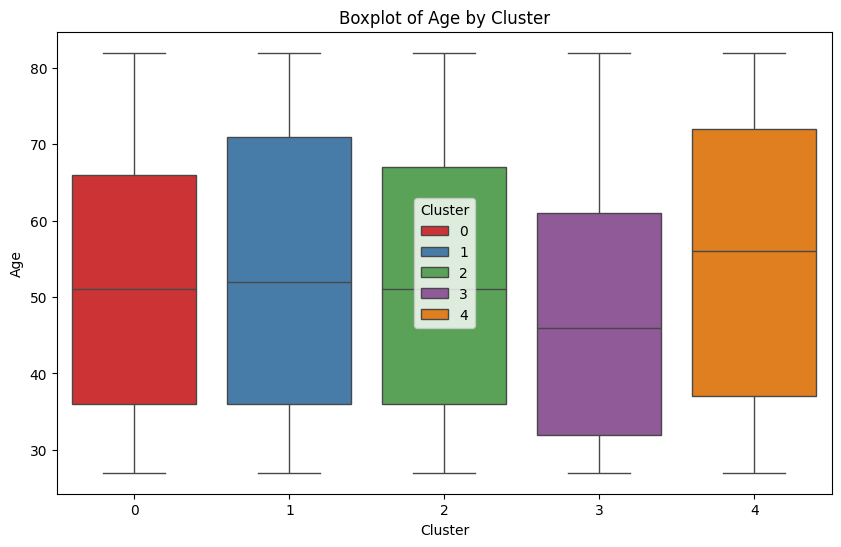

In [ ]:
# Step 28: Display a boxplot for each of the 5 features with the legend as the Clusters

plt.figure(figsize=(10,6))

sns.boxplot(x='Cluster', y='Frequency', data=clean_k, hue='Cluster', palette='Set1')

plt.title('Boxplot of Frequency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10,6))

sns.boxplot(x='Cluster', y='Recency', data=clean_k, hue='Cluster', palette='Set1')

plt.title('Boxplot of Recency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recency')
plt.show()

plt.figure(figsize=(10,6))

sns.boxplot(x='Cluster', y='CLV', data=clean_k, hue='Cluster', palette='Set1')

plt.title('Boxplot of CLV by Cluster')
plt.xlabel('Cluster')
plt.ylabel('CLV')
plt.show()

plt.figure(figsize=(10,6))

sns.boxplot(x='Cluster', y='Average Unit Cost', data=clean_k, hue='Cluster', palette='Set1')

plt.title('Boxplot of Average Unit Cost by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Unit Cost')
plt.show()

plt.figure(figsize=(10,6))

sns.boxplot(x='Cluster', y='Age', data=clean_k, hue='Cluster', palette='Set1')
plt.title('Boxplot of Age by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.show()

Clusters 1 and 4 are made up of customers who have not made a purchase in 2 and 4 years respectively, as such they are unlikely to be reengaged. It may be prudent to remove customers who have not made a purchase within the last 12 months from the dataset and try clustering again.

Clusters 0 and 2 show significant overlap on the tSNE plot and also show little difference on the boxplots. However it is difficult to tell due to the large spread of the data in the CLV and Average Unit Cost features. Removing more anomalies, removing anomalies in a different manner, or trying new features, are all potential next steps to gain clarity.

That leaves Cluster 3 - which has a higher median CLV and Average Unit Cost, suggesting these are high value customers. These customers are on average younger but make purchases less frequently. These two characteristics suggest that these customers have potential to continue to be customers for a long time, and could generate more value if they could be persuaded through targeted marketing to make more frequent purchases.

### Reference:
SAS, 2024. CUSTOMERS_CLEAN [Data set]. SAS. Last revised on 15 December 2021. [Accessed 20 February 2024].